# Strategy

- Preprocessing
    - Remove ctrl_vehicle
    - RankGauss
    - PCA + Existing Features
    - KMeans
    - Basic stats
- Model
    - Multi head ResNet (tensorflow)
    - TabNet (pytorch)
- Training
    - Pre-train with non-scored target.
    - Train with public test pseudo label
    - CV without drug_id
    - Optimizer: Adam/AdamW with weight_decay
    - Loss: BCE with Label smoothing + Logits
- Prediction
    - Ensemble above with average.

# Score

| Version | LB      | CV                   | AUC                | CV Strategy | Comment |
| ---     | ---     | ---                  | ---                | ---         | ---     |
| v65     | 0.01823 | 0.01617542475216824  | -                  | old         | -       |
| v80     | 0.01837 | 0.01667020593849     | 0.6648896787429924 | new         | *1      |
| v82     | 0.01831 | 0.015602756672807215 | 0.8186556909524331 | old         | *1      |
| v84     | 0.01835 | 0.016074252564811344 | 0.7612621209944287 | ensemble    | *1      |
| v85     | 0.01828 | 0.015434994072972176 | 0.8286985624571163 | old         | -       |

*1) Same model.


# Change Log

- v65
    - Remove clipping.
    - Disable Variance Encoding.
- v66
    - Add AUC.
    - CV only with original training data.
- v67
    - Add `train_drug.csv` .
    - Add Drug and MultiLabel Stratification.
- v68
    - Remove public test pseudo label.
    - Enable pseudo labeling.
    - Disable pre-training with non-scored target.
- V69
    - Disable pseudo labeling.
    - Re-enable pre-training with non-scored target.
    - Re-add public test pseudo label.
    - Add correlation.
    - Update label smoothing parameter.
- v70
    - Amend num of seed.
- v71
    - Update model parameters.
        - ResNet network
        - TabNet dimension
- v72
    - Add KMeans and basic stats.
    - Add NODE model.
- v73
    - Update split condition of group multilabel stratified kfold.
    - Update NODE parameters.
- v74
    - Disable pre-train with non-scored target due to execution time reduction.
- v75
    - Fold 5 to 7.
- v76
    - Remove ResNet for execution time reduction.
- v77
    - Use 3 models. ["ResNet", "TabNet", "NODE"]
    - Enable pre-train for ResNet.
- v78
    - Reset fold eash seeds.
- v79
    - Add simple NN model again.
    - Fold 7 to 5.
- v80
    - Remove simple NN and NODE model.
    - Increase num of seed x2 to x3.
- v81
    - Use ctrl_vehicle.
- v82
    - Remove ctrl_vehicle.
    - Add flag to disable cv_with_drug_id. Disable for now.
        - It may be good options that
            - is enabled for parameter tuning.
            - is disabled for training.
- v83
    - Change input of ResNet network.
- v84
    - Revert v83.
    - Ensemble old and new cv predictions.
- v85
    - Separate model by CV.
    - Use old cv oriented model.
- v86
    - Update public test label to v65.


# Setup

## Variables

In [77]:
import sys
IN_COLAB = 'google.colab' in sys.modules

In [78]:
# This variable is remained for only compatibility.
# No affect is occered to change this variable.
CV_WITH_DRUG_ID = True

In [79]:
USE_PUBLIC_TEST_PSEUDO_LABEL = True

In [80]:
PRE_TRAIN_NON_SCORED_TARGET = True

In [81]:
HYPER_PARAMETER_TUNING = False

if HYPER_PARAMETER_TUNING:
    USE_PUBLIC_TEST_PSEUDO_LABEL = False
    PRE_TRAIN_NON_SCORED_TARGET = True

## for Google Colab

In [82]:
COMPETE = "lish-moa"
DATASETS = [
    "imokuri/pytorchtabnet",
    "imokuri/moapublictestpredictions",
    "tolgadincer/autograd",
    "yasufuminakama/iterative-stratification",
    "rahulsd91/moapublictest",
]
PACKAGES = [
    "optuna"
]

In [83]:
if IN_COLAB:
    !pip install -q -U git+https://github.com/IMOKURI/kaggle_on_google_colab.git

    from kaggle_on_google_colab import setup
    kaggle = setup.Setup()
    kaggle.dirs(COMPETE)

    !kaggle competitions download -p /content/zip {COMPETE}
    for line in setup.exec_get_lines(cmd=f"kaggle competitions files --csv {COMPETE} | egrep -v \"Warning: Looks like you're using an outdated API Version|name,size,creationDate\" | cut -d , -f 1"):
        !unzip -q -n /content/zip/{line.decode().strip()}.zip -d /content/{COMPETE}/input/{COMPETE}

    for dataset in DATASETS:
        dataset_name = dataset.split("/")[-1]

        !kaggle datasets download -p /content/zip {dataset}
        !unzip -q -n /content/zip/{dataset_name}.zip -d /content/{COMPETE}/input/{dataset_name}

    for package_ in PACKAGES:
        !pip install -q {package_}

    !pip install -q -U tensorflow-addons
    !mv /content/zip/train_drug.csv /content/{COMPETE}/input/{COMPETE}/

    %cd /content/{COMPETE}/output

Download 100%.
  0% 0.00/535k [00:00<?, ?B/s]
100% 535k/535k [00:00<00:00, 86.7MB/s]
train_targets_nonscored.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_targets_scored.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_features.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_features.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open /content/zip/train_drug.csv.zip, /content/zip/train_drug.csv.zip.zip or /content/zip/train_drug.csv.zip.ZIP.
pytorchtabnet.zip: Skipping, found more recently modified local copy (use --force to force download)
moapublictestpredictions.zip: Skipping, found more recently modified local copy (use --force to force download)
autograd.zip: Skip

## Library

In [84]:
import warnings

warnings.filterwarnings("ignore")

In [85]:
import sys

sys.path.append("../input/iterative-stratification/iterative-stratification-master")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

sys.path.append("../input/autograd")
import autograd.numpy as np
from autograd import grad

sys.path.append("../input/pytorchtabnet")
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

#sys.path.append("../input/adabelief010")
#from AdaBelief import AdaBelief
#from AdaBelief_tf import AdaBeliefOptimizer

In [86]:
import datetime
import gc
import itertools
import os
import random
from collections import defaultdict
from time import time
from typing import Optional

import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.regularizers as R
import tensorflow_addons as tfa
import torch
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import fsolve, minimize
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import QuantileTransformer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow_probability import distributions as tfp_distributions
from tensorflow_probability import stats as tfp_stats
from torch import nn
from torch.nn.modules.loss import _WeightedLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau as torch_ReduceLROnPlateau

In [87]:
if HYPER_PARAMETER_TUNING:
    import optuna

In [88]:
if IN_COLAB:
    from IPython.display import SVG, display_svg
    from tensorflow.keras.utils import model_to_dot

In [89]:
# import numpy as np

In [90]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision

    if tpu:
        policy = tf.keras.mixed_precision.experimental.Policy("mixed_bfloat16")
    else:
        policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
    mixed_precision.set_policy(policy)
    print("Mixed precision enabled")

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print("Accelerated Linear Algebra enabled")

Accelerated Linear Algebra enabled


In [91]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Functions

In [92]:
def fix_seed(seed=2020):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


random_seed = 22
fix_seed(random_seed)

## Metrics

In [93]:
# Evaluation Metric with sigmoid applied and clipping

## for tensorflow
def logloss(y_true, y_pred):
    logits = 1 / (1 + K.exp(-y_pred))
    aux = (1 - y_true) * K.log(1 - logits + 1e-15) + y_true * K.log(logits + 1e-15)
    return K.mean(-aux)

## for pytorch
class LogitsLogLoss(Metric):
    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 1e-15) + y_true * np.log(logits + 1e-15)
        return np.mean(-aux)

## for overall
## [Fast Numpy Log Loss] https://www.kaggle.com/gogo827jz/optimise-blending-weights-4-5x-faster-log-loss
def metric(y_true, y_pred):
    loss = 0
    for i in range(y_pred.shape[1]):
        loss += -np.mean(y_true[:, i] * np.log(y_pred[:, i] + 1e-15) + (1 - y_true[:, i]) * np.log(1 - y_pred[:, i] + 1e-15))
    return loss / y_pred.shape[1]

## Loss functions

In [94]:
# https://www.kaggle.com/felipebihaiek/torch-continued-from-auxiliary-targets-smoothing
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction="mean", smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets: torch.Tensor, n_labels: int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1), self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets, self.weight)

        if self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()

        return loss

## Cross Validation

In [95]:
# Blend oof predictions
def blend(size, weights, oof):
    blend_ = np.zeros(size)
    for i, key in enumerate(oof.keys()):
        blend_ += weights[i] * oof[key].values[:blend_.shape[0], :blend_.shape[1]]
    return blend_

In [96]:
def cross_validation(size, weight, y_true, oof):
    x = size[0]
    blend_ = blend(y_true[:x].shape, weight, oof)

    aucs = []
    for task_id in range(blend_.shape[1]):
        aucs.append(roc_auc_score(y_true=y_true[:x, task_id], y_score=blend_[:, task_id]))
        
    CV = metric(y_true[:x], blend_)
    AUC = np.mean(aucs)
    print(f"Blended CV: {CV}, AUC : {AUC}")

    return CV, AUC

# Load Data

In [97]:
train_df = pd.read_csv("../input/lish-moa/train_features.csv")
test_df = pd.read_csv("../input/lish-moa/test_features.csv")
target_df = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
non_target_df = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
submit_df = pd.read_csv("../input/lish-moa/sample_submission.csv")
drug_df = pd.read_csv('../input/lish-moa/train_drug.csv')

pub_test_df = pd.read_csv("../input/moapublictest/test_features.csv")
#pub_submit_df = pd.read_csv("../input/moapublictestpredictions/submission-blendblendblend.csv")
pub_submit_df = pd.read_csv("../input/moapublictestpredictions/submission-v65-old_best_lb.csv")

In [98]:
train = train_df.copy()
test = test_df.copy()
target = target_df.copy()
non_target = non_target_df.copy()
ss = submit_df.copy()
drug = drug_df.copy()

pub_test = pub_test_df.copy()
pub_ss = pub_submit_df.copy()

## Use public test data for training

In [99]:
# Merge public test data (and pseudo label) into train data
if USE_PUBLIC_TEST_PSEUDO_LABEL:
    train = pd.concat([train, pub_test]).reset_index(drop=True)
    target = pd.concat([target, pub_ss]).reset_index(drop=True)

In [100]:
target

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,id_000779bfc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,id_000a6266a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_0015

# Preprocessing

In [101]:
train.loc[:, "cp_dose"] = train.loc[:, "cp_dose"].map({"D1": 0, "D2": 1})
test.loc[:, "cp_dose"] = test.loc[:, "cp_dose"].map({"D1": 0, "D2": 1})

In [102]:
train.loc[:, "cp_time"] = train.loc[:, "cp_time"].map({24: 0, 48: 1, 72: 2})
test.loc[:, "cp_time"] = test.loc[:, "cp_time"].map({24: 0, 48: 1, 72: 2})

## Remove ctrl_vehicle



In [103]:
USE_CTRL_VEHICLE = False

if USE_CTRL_VEHICLE:
    train.loc[:, "cp_type"] = train.loc[:, "cp_type"].map({"ctl_vehicle": 0, "trt_cp": 1})
    test.loc[:, "cp_type"] = test.loc[:, "cp_type"].map({"ctl_vehicle": 0, "trt_cp": 1})

else:
    target = target.loc[train["cp_type"] != "ctl_vehicle"].reset_index(drop=True)
    non_target = non_target.loc[train[: train_df.shape[0]]["cp_type"] != "ctl_vehicle"].reset_index(drop=True)

    train = train.loc[train["cp_type"] != "ctl_vehicle"].reset_index(drop=True)

    train = train.drop("cp_type", axis=1)
    test = test.drop("cp_type", axis=1)

## Merge drug_id into training data

https://www.kaggle.com/c/lish-moa/discussion/195195

In [104]:
target_drug = pd.DataFrame(target.loc[:, "sig_id"]).merge(drug, on='sig_id', how='left')
non_target_drug = pd.DataFrame(non_target.loc[:, "sig_id"]).merge(drug, on='sig_id', how='left')

In [105]:
target_drug = target_drug.fillna("xxxxxxxxx")
non_target_drug = non_target_drug.fillna("xxxxxxxxx")

In [106]:
target_drug

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131
...,...,...
25567,id_ff7004b87,xxxxxxxxx
25568,id_ff925dd0d,xxxxxxxxx
25569,id_ffb710450,xxxxxxxxx
25570,id_ffbb869f2,xxxxxxxxx


## Remove sig_id

In [107]:
del train["sig_id"]
del target["sig_id"]
del non_target["sig_id"]
del test["sig_id"]
del ss["sig_id"]

In [108]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,0.0640,-0.6316,-1.1990,0.7312,0.2752,0.8771,0.7721,-0.6836,-0.7374,-1.1620,0.1262,0.2718,0.3968,-1.1580,0.9891,-0.7642,0.6810,0.8971,0.1092,0.6508,-0.9330,0.1292,-0.5895,0.4987,-0.1180,0.3460,0.6819,-0.9072,1.3150,-0.2573,0.8935,0.7214,...,-0.799

In [109]:
print(train.shape)
print(target.shape)
print(non_target.shape)

print(test.shape)
print(ss.shape)

(25572, 874)
(25572, 206)
(21948, 402)
(3982, 874)
(3982, 206)


## Rank Gauss

https://www.kaggle.com/nayuts/moa-pytorch-nn-pca-rankgauss



In [110]:
g_cols = [col for col in train_df.columns if col.startswith("g-")]
c_cols = [col for col in train_df.columns if col.startswith("c-")]

for col in g_cols + c_cols:
    transformer = QuantileTransformer(n_quantiles=100, random_state=random_seed, output_distribution="normal")

    vec_len = len(train[col].values)
    vec_len_test = len(test[col].values)

    raw_vec = train[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test[col] = transformer.transform(test[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [111]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,0.753323,0.794765,0.536167,1.338760,0.180776,0.208658,0.241756,1.965646,-0.688984,1.877736,-0.053519,1.143981,0.924975,1.487242,0.228508,0.098206,0.580606,1.324588,0.969837,-0.769497,1.920660,0.980432,-0.523024,0.203658,2.228488,0.273028,0.825679,-0.144315,-1.094448,1.058674,0.428869,0.384250,1.300482,0.879422,-0.206096,1.046155,-0.479268,0.339234,0.583214,0.696712
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,0.641535,0.121409,0.568593,1.118831,0.454106,0.650547,-0.358860,-0.361880,-0.731374,0.450942,-0.080700,0.412389,0.712822,0.922701,0.171794,1.214918,0.776700,-0.391091,-0.085258,0.650690,-0.333287,1.210876,0.888810,0.508101,0.261893,0.662629,1.437773,1.216110,-0.512104,0.516588,-0.499745,1.147297,0.728062,0.089253,0.453665,0.770909,0.226300,0.202945,0.955497,1.219730
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,-0.605904,-0.850915,-0.054309,0.286723,0.031430,-1.247900,-0.570435,0.197865,-0.606533,-0.045253,0.249970,-0.525428,0.793715,0.255616,0.355135,1.566886,-0.059264,-0.124015,0.178685,0.114487,-0.979904,-0.821793,-0.132876,-0.723340,0.483937,0.184571,0.170784,-0.410592,0.466286,-0.067793,-0.800373,-0.721883,0.960080,0.088259,-1.182700,-0.358059,-0.732238,-0.253014,-1.085791,1.140342
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,-1.361762,-0.423345,-1.442027,-1.428508,-1.525756,-1.091653,-1.273684,-1.471056,0.466023,-0.357272,-1.088287,-0.594874,-1.354721,-1.249560,-1.322549,-1.075144,-1.550731,-1.527866,-1.578235,-1.238973,-0.650394,-1.458096,-1.422557,-1.113552,-1.504412,-1.313757,-1.490512,-1.095646,-1.391057,0.403256,-1.391931,-0.736149,-1.612415,-1.219207,-0.912980,-1.194806,-1.288428,-0.950502,-0.445204,-0.884754
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,-0.245683,0.538397,0.223240,-0.533109,-0.677480,0.621314,0.206440,0.793971,0.809832,0.922034,0.269679,-0.502938,1.247647,1.017769,0.676487,0.742572,0.077297,0.811880,1.005072,-0.465291,-1.264604,-0.986090,-0.061454,0.95

## PCA features (+ Existing features)



In [112]:
# g-
n_comp = 50

data = pd.concat([pd.DataFrame(train[g_cols]), pd.DataFrame(test[g_cols])])
data2 = PCA(n_components=n_comp, random_state=random_seed).fit_transform(data[g_cols])
train2 = data2[: train.shape[0]]
test2 = data2[-test.shape[0] :]

train2 = pd.DataFrame(train2, columns=[f"pca_G-{i}" for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f"pca_G-{i}" for i in range(n_comp)])

train = pd.concat((train, train2), axis=1)
test = pd.concat((test, test2), axis=1)

In [113]:
# c-
n_comp = 15

data = pd.concat([pd.DataFrame(train[c_cols]), pd.DataFrame(test[c_cols])])
data2 = PCA(n_components=n_comp, random_state=random_seed).fit_transform(data[c_cols])
train2 = data2[: train.shape[0]]
test2 = data2[-test.shape[0] :]

train2 = pd.DataFrame(train2, columns=[f"pca_C-{i}" for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f"pca_C-{i}" for i in range(n_comp)])

train = pd.concat((train, train2), axis=1)
test = pd.concat((test, test2), axis=1)

In [114]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,pca_G-25,pca_G-26,pca_G-27,pca_G-28,pca_G-29,pca_G-30,pca_G-31,pca_G-32,pca_G-33,pca_G-34,pca_G-35,pca_G-36,pca_G-37,pca_G-38,pca_G-39,pca_G-40,pca_G-41,pca_G-42,pca_G-43,pca_G-44,pca_G-45,pca_G-46,pca_G-47,pca_G-48,pca_G-49,pca_C-0,pca_C-1,pca_C-2,pca_C-3,pca_C-4,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,1.707058,1.421147,-0.700530,-0.425062,0.940237,0.767837,0.507995,0.644794,1.325287,-0.497782,-0.156981,1.893770,0.717011,-1.480837,-1.351221,0.207564,-0.175343,1.360125,0.496425,-1.700937,-0.817586,-0.531024,-0.275368,-0.956808,-0.896364,5.123632,1.649841,1.121618,1.358399,0.886176,1.084173,0.499893,0.361410,-0.060848,0.345115,0.430001,0.294952,0.457666,-1.104604,0.746927
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,-1.119543,1.011087,0.214039,0.226216,-1.000243,2.809382,0.026496,-0.574495,0.940675,3.141940,-0.214647,-0.068359,-1.777449,-1.413097,1.026146,0.175405,-0.845935,0.342264,-0.032609,1.473968,-0.228058,-0.599268,-0.543869,-1.919857,-0.727375,5.285763,-0.349169,1.118871,0.067914,-0.314655,-0.644772,-0.072663,0.691390,-0.915782,0.139468,1.039007,0.163256,-0.388631,-1.131308,-0.578330
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,-1.298401,-1.215477,-1.676072,-0.808715,0.385964,0.959366,3.335335,1.353128,-1.096469,-2.241281,2.512620,-2.790400,1.869257,-1.165789,-0.925992,1.504974,2.139975,-1.655908,0.613634,-0.013835,-0.549096,2.812813,0.568198,-0.805516,0.658570,-1.146132,0.445421,-0.061150,0.221494,-0.149379,1.014754,-0.962508,1.009455,-0.254046,-0.406054,0.674100,0.071775,0.290638,0.701243,-0.010055
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,-0.415765,1.029610,-1.110971,-2.381406,-0.343528,2.389168,-2.841859,2.474042,2.506283,2.213779,-2.357117,-3.295627,4.830398,2.853403,0.700740,0.292390,1.176555,1.617675,1.524163,-0.435527,1.255777,-1.243932,1.126426,-0.353581,-0.552100,-10.666017,1.342991,-1.514119,0.709308,-0.088064,0.871548,0.699965,0.872746,-0.628334,0.962443,2.251942,1.342743,-0.423853,-0.559250,0.182839
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,-2.933909,0.206176,1.292821,0.883372,-0.733935,0.070326,-1.391824,-0.555

In [115]:
train_pca = train.copy()
test_pca = test.copy()

train_pca.drop(g_cols, axis=1, inplace=True)
test_pca.drop(g_cols, axis=1, inplace=True)

train_pca.drop(c_cols, axis=1, inplace=True)
test_pca.drop(c_cols, axis=1, inplace=True)

In [116]:
train_pca

,cp_time,cp_dose,pca_G-0,pca_G-1,pca_G-2,pca_G-3,pca_G-4,pca_G-5,pca_G-6,pca_G-7,pca_G-8,pca_G-9,pca_G-10,pca_G-11,pca_G-12,pca_G-13,pca_G-14,pca_G-15,pca_G-16,pca_G-17,pca_G-18,pca_G-19,pca_G-20,pca_G-21,pca_G-22,pca_G-23,pca_G-24,pca_G-25,pca_G-26,pca_G-27,pca_G-28,pca_G-29,pca_G-30,pca_G-31,pca_G-32,pca_G-33,pca_G-34,pca_G-35,pca_G-36,pca_G-37,pca_G-38,pca_G-39,pca_G-40,pca_G-41,pca_G-42,pca_G-43,pca_G-44,pca_G-45,pca_G-46,pca_G-47,pca_G-48,pca_G-49,pca_C-0,pca_C-1,pca_C-2,pca_C-3,pca_C-4,pca_C-5,pca_C-6,pca_C-7,pca_C-8,pca_C-9,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14
0,0,0,-5.778899,6.154613,8.561315,-7.442511,4.386002,1.258147,3.520685,1.828526,2.566195,0.446245,0.758741,1.807036,2.231582,-0.254969,1.353139,0.461821,-0.376327,0.324485,1.210639,0.693050,-0.168277,-1.757475,0.930942,-0.041697,-0.754251,1.707058,1.421147,-0.700530,-0.425062,0.940237,0.767837,0.507995,0.644794,1.325287,-0.497782,-0.156981,1.893770,0.717011,-1.480837,-1.351221,0.207564,-0.175343,1.360125,0.496425,-1.700937,-0.817586,-0.531024,-0.275368,-0.956808,-0.896364,5.123632,1.649841,1.121618,1.358399,0.886176,1.084173,0.499893,0.361410,-0.060848,0.345115,0.430001,0.294952,0.457666,-1.104604,0.746927
1,2,0,-5.035246,1.003536,-12.642795,4.682019,0.934481,0.017921,0.817860,-1.085419,3.906072,3.868931,-0.792203,-1.457644,0.144082,-1.036227,-0.097660,-2.914543,-0.319084,-0.674986,-0.892477,0.498397,1.445716,0.068527,-2.310474,0.856457,-2.741299,-1.119543,1.011087,0.214039,0.226216,-1.000243,2.809382,0.026496,-0.574495,0.940675,3.141940,-0.214647,-0.068359,-1.777449,-1.413097,1.026146,0.175405,-0.845935,0.342264,-0.032609,1.473968,-0.228058,-0.599268,-0.543869,-1.919857,-0.727375,5.285763,-0.349169,1.118871,0.067914,-0.314655,-0.644772,-0.072663,0.691390,-0.915782,0.139468,1.039007,0.163256,-0.388631,-1.131308,-0.578330
2,1,0,0.849837,-8.534120,-2.961085,0.234691,0.712903,3.226471,-1.540530,3.543483,-1.232619,-4.634329,1.072835,1.369636,1.233364,-1.089154,0.692024,-1.659910,-1.569639,-0.763372,2.029549,-1.019353,-2.299365,1.353089,1.230355,-1.788850,-1.230381,-1.298401,-1.215477,-1.676072,-0.808715,0.385964,0.959366,3.335335,1.353128,-1.096469,-2.241281,2.512620,-2.790400,1.869257,-1.165789,-0.925992,1.504974,2.139975,-1.655908,0.613634,-0.013835,-0.549096,2.812813,0.568198,-0.805516,0.658570,-1.146132,0.445421,-0.061150,0.221494,-0.149379,1.014754,-0.962508,1.009455,-0.254046,-0.406054,0.674100,0.071775,0.290638,0.701243,-0.010055
3,1,0,11.053726,-10.088315,-0.812731,-4.941979,-7.323094,-2.490876,-2.273711,6.357738,-4.686070,0.376654,-2.622815,-4.480198,-3.635855,0.595886,0.062677,0.756626,-0.822791,-0.403819,0.633504,-2.889031,-2.516641,1.194352,-0.201905,-0.500804,-2.886582,-0.415765,1.029610,-1.110971,-2.381406,-0.343528,2.389168,-2.841859,2.474042,2.506283,2.213779,-2.357117,-3.295627,4.830398,2.853403,0.700740,0.292390,1.176555,1.617675,1.524163,-0.435527,1.255777,-1.243932,1.126426,-0.353581,-0.552100,-10.666017,1.342991,-1.514119,0.709308,-0.088064,0.871548,0.699965,0.872746,-0.628334,0.962443,2.251942,1.342743,-0.423853,-0.559250,0.182839
4,2,1,-6.813030,-5.481174,-9.282727,-4.827295,-7.899419,-8.227711,-3.362621,-3.581453,-1.096231,-2.306174,-2.813715,-3.706832,-1.038621,4.053344,-3.872539,0.734540,-0.829388,1.213439,3.181971,0.181893,-0.476675,0.739371,0.536824,-0.944253,-2.658616,-2.933909,0.206176,1.292821,0.883372,-0.733935,0.070326,-1.391824,-0.555145,1.019491,3.748793,-1.717172,1.331667,0.285762,1.739585,0.697087,-0.046181,-2.453530,-0.640449,1.346191,0.132122,0.795487,-0.789090,0.844920,0.680624,0.531089,3.839664,0.721784,-0.199844,0.551240,0.286538,-0.245337,-0.583627,0.459293,0.373390,-0.289508,0.667770,-0.944482,0.211168,-0.347195,0.160099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,3.034423,-2.604996,

## feature Selection using Variance Encoding



In [117]:
# https://www.kaggle.com/c/lish-moa/discussion/194973#1067941
if False:

    var_threshold = 0.5

    data = train.append(test)
    ve_columns = (data.iloc[:, 2:].var() >= var_threshold).values
    ve_data = data.iloc[:, 2:].loc[:, ve_columns]

    ve_train = ve_data[: train.shape[0]]
    ve_test = ve_data[-test.shape[0] :]


    train = pd.DataFrame(train[["cp_time", "cp_dose"]].values.reshape(-1, 2), columns=["cp_time", "cp_dose"])
    train = pd.concat([train, ve_train], axis=1)


    test = pd.DataFrame(test[["cp_time", "cp_dose"]].values.reshape(-1, 2), columns=["cp_time", "cp_dose"])
    test = pd.concat([test, ve_test], axis=1)

In [118]:
# train

## KMeans

In [119]:
%%time

features_g = [col for col in train.columns if col.startswith("g-")]
features_c = [col for col in train.columns if col.startswith("c-")]

def fe_cluster(train_, test_, n_clusters_g = 35, n_clusters_c = 5):

    def create_cluster(tr, te, features, kind = 'g', n_clusters = n_clusters_g):
        tmp_train_ = tr[features].copy()
        tmp_test_ = te[features].copy()
        data = pd.concat([tmp_train_, tmp_test_], axis = 0)

        kmeans = KMeans(n_clusters = n_clusters, random_state = random_seed).fit(data)
        
        tr[f'clusters_{kind}'] = kmeans.labels_[:tr.shape[0]]
        te[f'clusters_{kind}'] = kmeans.labels_[-te.shape[0]:]
        tr = pd.get_dummies(tr, columns = [f'clusters_{kind}'])
        te = pd.get_dummies(te, columns = [f'clusters_{kind}'])
        return tr, te
    
    train_, test_ = create_cluster(train_, test_, features_g, kind = 'g', n_clusters = n_clusters_g)
    train_, test_ = create_cluster(train_, test_, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train_, test_

train, test = fe_cluster(train, test)

CPU times: user 2min 24s, sys: 8.1 s, total: 2min 33s
Wall time: 2min 9s


In [120]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,clusters_g_0,clusters_g_1,clusters_g_2,clusters_g_3,clusters_g_4,clusters_g_5,clusters_g_6,clusters_g_7,clusters_g_8,clusters_g_9,clusters_g_10,clusters_g_11,clusters_g_12,clusters_g_13,clusters_g_14,clusters_g_15,clusters_g_16,clusters_g_17,clusters_g_18,clusters_g_19,clusters_g_20,clusters_g_21,clusters_g_22,clusters_g_23,clusters_g_24,clusters_g_25,clusters_g_26,clusters_g_27,clusters_g_28,clusters_g_29,clusters_g_30,clusters_g_31,clusters_g_32,clusters_g_33,clusters_g_34,clusters_c_0,clusters_c_1,clusters_c_2,clusters_c_3,clusters_c_4
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,0.599819,-0.723658,2.333805,-0.964385,1.075072,1.786462,0.131113,-0.812649,-1.262773,0.715625,0.318285,0.931852,0.891035,-0.949397,-0.790157,-1.741802,-0.005935,0.422248,0.782906,-1.426283,1.337238,-0.984105,0.945577,1.522781,0.125583,0.996436,-1.051023,0.081923,-0.948024,0.652998,-0.221651,0.524692,1.171730,-1.160303,1.590993,-0.336634,1.158396,1.116065,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
25568,0,0,-0.865375,-0.307222,1.988666,0.523322,0.644383,0.437283,-0.989775,-0.015526,0.361388,1.882095,0.212718,0.455477,0.989702,-1.349989,0.292528,2.255815,1.324086,-0.214699,0.743628,0.881515,0.879294,-0.96039

## Basic stats

In [121]:
for stats in ["sum", "mean", "std", "kurt", "skew"]:
    train["g_" + stats] = getattr(train[features_g], stats)(axis = 1)
    train["c_" + stats] = getattr(train[features_c], stats)(axis = 1)
    train["gc_" + stats] = getattr(train[features_g + features_c], stats)(axis = 1)
    
    test["g_" + stats] = getattr(test[features_g], stats)(axis = 1)
    test["c_" + stats] = getattr(test[features_c], stats)(axis = 1)
    test["gc_" + stats] = getattr(test[features_g + features_c], stats)(axis = 1)

In [122]:
train

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,clusters_g_15,clusters_g_16,clusters_g_17,clusters_g_18,clusters_g_19,clusters_g_20,clusters_g_21,clusters_g_22,clusters_g_23,clusters_g_24,clusters_g_25,clusters_g_26,clusters_g_27,clusters_g_28,clusters_g_29,clusters_g_30,clusters_g_31,clusters_g_32,clusters_g_33,clusters_g_34,clusters_c_0,clusters_c_1,clusters_c_2,clusters_c_3,clusters_c_4,g_sum,c_sum,gc_sum,g_mean,c_mean,gc_mean,g_std,c_std,gc_std,g_kurt,c_kurt,gc_kurt,g_skew,c_skew,gc_skew
0,0,0,1.124260,0.896698,-0.436214,-0.965311,-0.287443,-1.016437,-1.360774,-0.045876,0.724289,-0.306480,1.548505,0.164968,0.662494,-0.546159,0.298915,-1.074307,-1.121108,0.911363,0.371674,-0.522346,-0.697832,-1.373744,-1.688513,1.251776,0.571647,0.442209,0.289814,0.124411,-0.483898,0.763732,0.424105,-1.104934,-0.059676,-0.410229,-0.238182,0.293279,0.385467,-0.575945,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-6.636412,51.006934,44.370522,-0.008596,0.510069,0.050884,0.868307,0.731294,0.869209,-0.270006,-0.321285,-0.270608,0.019115,0.073814,-0.015508
1,2,0,0.117451,0.667759,0.260124,0.097531,1.204172,0.692876,0.356691,0.559630,-0.499964,0.840338,-1.248650,-0.586659,-0.179771,0.551390,0.165188,0.383668,0.415148,0.437966,-0.851699,0.492650,1.281884,-0.147127,-0.417569,-0.458679,0.402005,-0.553175,0.685267,0.180693,-0.710243,-0.210095,-0.120832,-0.549719,1.682192,-0.338723,0.319680,-0.271026,0.202252,0.802836,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2.114491,52.185200,54.299691,0.002739,0.521852,0.062270,0.850889,0.608372,0.842821,-0.217545,0.088938,-0.233240,0.045890,-0.163448,-0.041249
2,1,0,0.777229,0.935347,1.414044,-0.113563,-0.025489,1.494313,0.277364,0.357917,0.041116,1.245681,-0.658295,-0.777567,-0.097484,-2.307836,0.893975,-0.560872,0.487001,-0.375699,-0.321293,-0.050883,-0.080260,-1.043271,-1.943930,0.533388,0.639600,0.740004,-1.354969,2.390299,-0.051039,1.584754,-1.430852,0.809052,0.740065,0.241147,-0.038376,-1.678522,0.147730,-0.147096,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-21.221452,-12.699072,-33.920524,-0.027489,-0.126991,-0.038900,0.941310,0.665178,0.914129,-0.356922,-0.182024,-0.286903,-0.044156,0.385872,-0.008376
3,1,0,-0.749489,-0.299404,-0.459100,0.774708,2.344556,-0.856449,-2.323390,0.298781,-0.148487,-1.363305,-1.013378,-0.505310,-1.117997,-0.801002,-1.751405,1.385583,-0.207445,-1.032568,0.234219,-2.131858,2.087263,-1.394787,-1.118537,-1.073357,-1.413282,0.037523,-1.026961,0.226259,-0.417838,-1.256155,-0.968977,0.126443,-2.079302,1.080824,0.751150,-2.150620,-1.403705,-1.036102,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,-12.275952,-106.929644,-119.205596,-0.015901,-1.069296,-0.136704,1.080671,0.576449,1.088267,-0.918764,3.952398,-0.959980,0.086528,1.953350,0.245358
4,2,1,-0.460555,-0.508226,0.959313,0.984009,1.451890,-0.867329,-0.342599,-0.234770,-1.028713,0.852815,-0.349205,-0.711421,-1.215140,1.175540,0.335191,0.334632,-0.007837,-1.548792,-0.862824,-0.718928,-0.421737,-0.311300,1.031298,0.493778,1.704934,1.045697,1.142858,-0.613764,-1.508111,0.360326,-0.153815,0.839727,1.145939,-0.109706,1.463205,-1.023032,-1.318688,1.649914,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-19.685019,37.486733,17.801714,-0.025499,0.374867,0.020415,1.103348,0.677183,1.070526,-0.214614,-0.723722,-0.102022,-0.187344,0.076016,-0.251234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,0,0,0.599819,-0.723658,2.333805,-0.964385,1.075072,1.786462,0.131113,-0.812649,-1.262773,0.715625,0.318285,0.931852,0.891035,-0.949397,-0.790157,-1.741802,-0.005935,0.422248,0.78

# Model - Simple NN

In [123]:
def create_model_simple_nn(num_col, output_dim):
    model = tf.keras.Sequential(
        [
            L.Input(num_col),
            L.BatchNormalization(),
            L.Dropout(0.4),
            tfa.layers.WeightNormalization(L.Dense(256, activation="elu")),
            L.BatchNormalization(),
            L.Dropout(0.3),
            tfa.layers.WeightNormalization(L.Dense(256, activation="swish")),
            L.BatchNormalization(),
            L.Dropout(0.3),
            tfa.layers.WeightNormalization(L.Dense(128, activation="selu")),
            L.BatchNormalization(),
            L.Dense(output_dim),
        ]
    )

    return model

# Model - Multi input ResNet

https://www.kaggle.com/rahulsd91/moa-multi-input-resnet-model

In [124]:
# New CV, Fold 5, Seed 2
#

def create_model_resnet(n_features, n_features_2, n_labels):
    input_1 = L.Input(shape=(n_features,), name="Input1")
    input_2 = L.Input(shape=(n_features_2,), name="Input2")

    block_1 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(256, activation="selu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="swish")),
        ],
        name="Block1",
    )

    output_1 = block_1(input_1)
    connection_1 = L.Concatenate(name="Connection1")([input_2, output_1])

    block_2 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(256, activation="swish")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(512, activation="relu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="relu")),
        ],
        name="Block2",
    )

    output_2 = block_2(connection_1)
    connection_2 = L.Average(name="Connection2")([output_1, output_2])

    block_3 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            tfa.layers.WeightNormalization(L.Dense(128, activation="relu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(128, activation="swish")),
            L.BatchNormalization(),
        ],
        name="Block3",
    )

    output_3 = block_3(connection_2)

    # output = L.Dense(n_labels, activation="sigmoid", name="Output")(output_3)
    output = L.Dense(n_labels, name="Output")(output_3)

    model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)

    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input1 (InputLayer)             [(None, 994)]        0                                            
__________________________________________________________________________________________________
Block1 (Sequential)             (None, 1024)         1042058     Input1[0][0]                     
__________________________________________________________________________________________________
Input2 (InputLayer)             [(None, 67)]         0                                            
__________________________________________________________________________________________________
Connection1 (Concatenate)       (None, 1091)         0           Input2[0][0]                     
                                                                 Block1[0][0]          

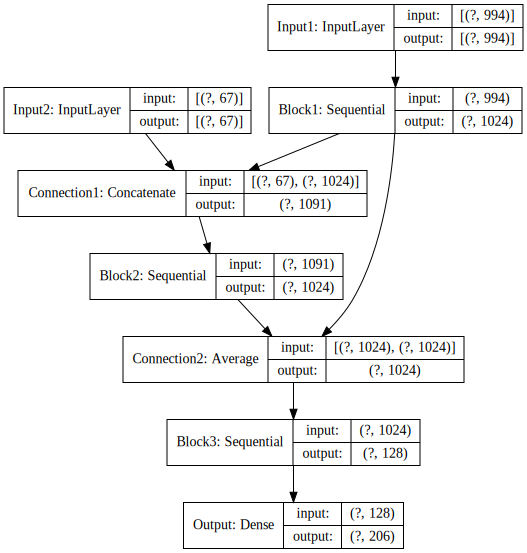

In [125]:
if IN_COLAB:
    model_test = create_model_resnet(len(train.columns), len(train_pca.columns), len(target.columns))
    model_test.summary()
    display_svg(SVG(model_to_dot(model_test, show_shapes=True, dpi=72).create(prog='dot', format='svg')))

In [126]:
# Old CV, Fold 5, Seed 2
# v65, CV: 0.015523946948687585, AUC : 0.8126217874432793
# current CV: 0.015457572493545903, AUC : 0.8352927817966078

def create_model_resnet_without_drug_id(n_features, n_features_2, n_labels):
    input_1 = L.Input(shape=(n_features,), name="Input1")
    input_2 = L.Input(shape=(n_features_2,), name="Input2")

    block_1 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(128, activation="elu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="swish")),
        ],
        name="Block1",
    )

    output_1 = block_1(input_1)
    connection_1 = L.Concatenate(name="Connection1")([input_2, output_1])

    block_2 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(512, activation="swish")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(256, activation="elu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="elu")),
        ],
        name="Block2",
    )

    output_2 = block_2(connection_1)
    connection_2 = L.Average(name="Connection2")([output_1, output_2])

    block_3 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="swish")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(1024, activation="swish")),
            L.BatchNormalization(),
        ],
        name="Block3",
    )

    output_3 = block_3(connection_2)

    # output = L.Dense(n_labels, activation="sigmoid", name="Output")(output_3)
    output = L.Dense(n_labels, name="Output")(output_3)

    model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)

    return model

In [127]:
def create_model_resnet_tuning(n_features, n_features_2, n_labels, params):
    n_hidden_layers = params["n_layers"]
    units = params["units"]
    activations = params["activations"]

    input_1 = L.Input(shape=(n_features,), name="Input1")
    input_2 = L.Input(shape=(n_features_2,), name="Input2")

    block_1 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[-3], activation=activations[-4])),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[n_hidden_layers - 1], activation=activations[-3])),
        ],
        name="Block1",
    )

    output_1 = block_1(input_1)
    connection_1 = L.Concatenate(name="Connection1")([input_2, output_1])

    layers_2 = []
    for i in range(n_hidden_layers):
        layers_2 += [
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[i], activation=activations[i])),
        ]
    block_2 = tf.keras.Sequential(layers_2, name="Block2")

    output_2 = block_2(connection_1)
    connection_2 = L.Average(name="Connection2")([output_1, output_2])

    block_3 = tf.keras.Sequential(
        [
            L.BatchNormalization(),
            tfa.layers.WeightNormalization(L.Dense(units[-2], activation=activations[-2])),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(units[-1], activation=activations[-1])),
            L.BatchNormalization(),
        ],
        name="Block3",
    )

    output_3 = block_3(connection_2)

    # output = L.Dense(n_labels, activation="sigmoid", name="Output")(output_3)
    output = L.Dense(n_labels, name="Output")(output_3)

    model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)

    return model

# Model - TabNet

In [128]:
# New CV, Fold 5, Seed 2
# 38, CV: 0.01717030924098107, AUC : 0.635771011871473

def create_model_tabnet(seed):
    tabnet_params = dict(
        n_d=38,
        n_a=38,
        n_steps=1,
        n_independent=1,
        n_shared=1,
        gamma=1.3,
        lambda_sparse=0,
        optimizer_fn=optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        #optimizer_fn=AdaBelief,
        #optimizer_params=dict(lr=2e-2, weight_decay=1e-5, weight_decouple=False),
        mask_type="entmax",
        scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, threshold=1e-5, factor=0.1),
        scheduler_fn=torch_ReduceLROnPlateau,
        seed=seed,
        verbose=0,
    )

    model = TabNetRegressor(**tabnet_params)

    return model

In [129]:
# Old CV, Fold 5, Seed 2
# 32, CV: 0.01610202071937643, AUC : 0.7927847288364558

def create_model_tabnet_without_drug_id(seed):
    tabnet_params = dict(
        n_d=32,
        n_a=32,
        n_steps=1,
        n_independent=1,
        n_shared=1,
        gamma=1.3,
        lambda_sparse=0,
        optimizer_fn=optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        #optimizer_fn=AdaBelief,
        #optimizer_params=dict(lr=2e-2, weight_decay=1e-5, weight_decouple=False),
        mask_type="entmax",
        scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, threshold=1e-5, factor=0.1),
        scheduler_fn=torch_ReduceLROnPlateau,
        seed=seed,
        verbose=0,
    )

    model = TabNetRegressor(**tabnet_params)

    return model

In [130]:
def create_model_tabnet_tuning(seed, params=None):
    tabnet_params = dict(
        n_d=params["dim"],
        n_a=params["dim"],
        n_steps=1,
        n_independent=1,
        n_shared=1,
        gamma=1.3,
        lambda_sparse=0,
        optimizer_fn=optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        #optimizer_fn=AdaBelief,
        #optimizer_params=dict(lr=2e-2, weight_decay=1e-5, weight_decouple=False),
        mask_type="entmax",
        scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, threshold=1e-5, factor=0.1),
        scheduler_fn=torch_ReduceLROnPlateau,
        seed=seed,
        verbose=0,
    )

    model = TabNetRegressor(**tabnet_params)

    return model

# Model - NODE

Neural Oblivious Decision Ensembles

https://www.kaggle.com/gogo827jz/moa-neural-oblivious-decision-ensembles-tf-keras

In [131]:
@tf.function
def sparsemoid(inputs: tf.Tensor):
    return tf.clip_by_value(0.5 * inputs + 0.5, 0.0, 1.0)

@tf.function
def identity(x: tf.Tensor):
    return x

In [132]:
class ODST(L.Layer):
    def __init__(self, n_trees: int = 3, depth: int = 4, units: int = 1, threshold_init_beta: float = 1.0):
        super(ODST, self).__init__()
        self.initialized = False
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta

    def build(self, input_shape: tf.TensorShape):
        feature_selection_logits_init = tf.zeros_initializer()
        self.feature_selection_logits = tf.Variable(
            initial_value=feature_selection_logits_init(
                shape=(input_shape[-1], self.n_trees, self.depth), dtype="float32"
            ),
            trainable=True,
            name="feature_selection_logits",
        )

        feature_thresholds_init = tf.zeros_initializer()
        self.feature_thresholds = tf.Variable(
            initial_value=feature_thresholds_init(shape=(self.n_trees, self.depth), dtype="float32"),
            trainable=True,
            name="feature_thresholds",
        )

        log_temperatures_init = tf.ones_initializer()
        self.log_temperatures = tf.Variable(
            initial_value=log_temperatures_init(shape=(self.n_trees, self.depth), dtype="float32"),
            trainable=True,
            name="log_temperatures",
        )

        indices = K.arange(0, 2 ** self.depth, 1)
        offsets = 2 ** K.arange(0, self.depth, 1)
        bin_codes = tf.reshape(indices, (1, -1)) // tf.reshape(offsets, (-1, 1)) % 2
        bin_codes_1hot = tf.stack([bin_codes, 1 - bin_codes], axis=-1)
        self.bin_codes_1hot = tf.Variable(
            initial_value=tf.cast(bin_codes_1hot, "float32"), trainable=False, name="bin_codes_1hot"
        )

        response_init = tf.ones_initializer()
        self.response = tf.Variable(
            initial_value=response_init(shape=(self.n_trees, self.units, 2 ** self.depth), dtype="float32"),
            trainable=True,
            name="response",
        )

    def initialize(self, inputs):
        feature_values = self.feature_values(inputs)

        # intialize feature_thresholds
        percentiles_q = 100 * tfp_distributions.Beta(self.threshold_init_beta, self.threshold_init_beta).sample(
            [self.n_trees * self.depth]
        )
        flattened_feature_values = tf.map_fn(K.flatten, feature_values)
        init_feature_thresholds = tf.linalg.diag_part(
            tfp_stats.percentile(flattened_feature_values, percentiles_q, axis=0)
        )

        self.feature_thresholds.assign(tf.reshape(init_feature_thresholds, self.feature_thresholds.shape))

        # intialize log_temperatures
        self.log_temperatures.assign(
            tfp_stats.percentile(tf.math.abs(feature_values - self.feature_thresholds), 50, axis=0)
        )

    def feature_values(self, inputs: tf.Tensor, training: bool = None):
        feature_selectors = tfa.activations.sparsemax(self.feature_selection_logits)
        # ^--[in_features, n_trees, depth]

        feature_values = tf.einsum("bi,ind->bnd", inputs, feature_selectors)
        # ^--[batch_size, n_trees, depth]

        return feature_values

    def call(self, inputs: tf.Tensor, training: bool = None):
        if not self.initialized:
            self.initialize(inputs)
            self.initialized = True

        feature_values = self.feature_values(inputs)

        threshold_logits_a = (feature_values - self.feature_thresholds) * tf.math.exp(-self.log_temperatures)

        threshold_logits_b = tf.stack([-threshold_logits_a, threshold_logits_a], axis=-1)
        # ^--[batch_size, n_trees, depth, 2]

        bins = sparsemoid(threshold_logits_b)
        # ^--[batch_size, n_trees, depth, 2], approximately binary

        bin_matches = tf.einsum("btds,dcs->btdc", bins, self.bin_codes_1hot)
        # ^--[batch_size, n_trees, depth, 2 ** depth]

        response_weights = tf.math.reduce_prod(bin_matches, axis=-2)
        # ^-- [batch_size, n_trees, 2 ** depth]

        response = tf.einsum("bnd,ncd->bnc", response_weights, self.response)
        # ^-- [batch_size, n_trees, units]

        return tf.reduce_sum(response, axis=1)

In [133]:
class NODE(tf.keras.Model):
    def __init__(
        self,
        units: int = 1,
        n_layers: int = 1,
        output_dim=1,
        dropout_rate=0.1,
        link: tf.function = tf.identity,
        n_trees: int = 3,
        depth: int = 4,
        threshold_init_beta: float = 1.0,
        feature_column: Optional[L.DenseFeatures] = None,
    ):
        super(NODE, self).__init__()
        self.units = units
        self.n_layers = n_layers
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta
        self.feature_column = feature_column
        self.dropout_rate = dropout_rate
        self.output_dim = output_dim

        if feature_column is None:
            self.feature = L.Lambda(identity)
        else:
            self.feature = feature_column

        self.bn = [L.BatchNormalization() for _ in range(n_layers + 1)]
        self.dropout = [L.Dropout(self.dropout_rate) for _ in range(n_layers + 1)]
        self.ensemble = [
            ODST(n_trees=n_trees, depth=depth, units=units, threshold_init_beta=threshold_init_beta)
            for _ in range(n_layers)
        ]

        self.last_layer = L.Dense(self.output_dim)

        self.link = link

    def call(self, inputs, training=None):
        X_a = self.feature(inputs)
        X_b = self.bn[0](X_a, training=training)
        X_c = self.dropout[0](X_b, training=training)

        X = defaultdict(dict)
        X[0][0] = X_c
        for i, tree in enumerate(self.ensemble):
            X[i][1] = tf.concat([X[i][0], tree(X[i][0])], axis=1)
            X[i][2] = self.bn[i + 1](X[i][1], training=training)
            X[i + 1][0] = self.dropout[i + 1](X[i][2], training=training)

        return self.link(self.last_layer(X[i + 1][0]))

In [134]:
def create_model_node(output_dim):
    model = tf.keras.Sequential(
        [
            NODE(
                n_layers=2,
                units=128,
                output_dim=128,
                dropout_rate=0.2,
                depth=3,
                n_trees=2,
            ),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(128, activation="elu")),
            L.BatchNormalization(),
            L.Dropout(0.2),
            tfa.layers.WeightNormalization(L.Dense(128, activation="swish")),
            L.BatchNormalization(),
            L.Dense(output_dim),  # from_logits=True
        ]
    )

    return model

# Training

In [135]:
models = [
    #{"model_name": "ResNet", "cv": "with_drug_id"},
    {"model_name": "ResNet", "cv": "without_drug_id"},
    #{"model_name": "TabNet", "cv": "with_drug_id"},
    {"model_name": "TabNet", "cv": "without_drug_id"},
]
N_STARTS = len(models) * 3
N_SPLITS = 5

if IN_COLAB:
    models = [
        {"model_name": "ResNet", "cv": "with_drug_id"},
        {"model_name": "ResNet", "cv": "without_drug_id"},
        {"model_name": "TabNet", "cv": "with_drug_id"},
        {"model_name": "TabNet", "cv": "without_drug_id"},
    ]
    N_STARTS = len(models) * 2
    N_SPLITS = 5

In [136]:
pre_train_models = ["ResNet", "SimpleNN"]

In [137]:
def learning(
    train_,
    train_pca_,
    target_,
    drug_,
    N_STARTS=6,
    N_SPLITS=5,
    do_predict=False,
    transfer_learning_base=None,
    pseudo_labeling=False,
    cv_with_drug_id=True,
    params=None,
):
    oof = {}
    predictions = {}

    for seed in range(N_STARTS):
        model_name = models[seed % len(models)]["model_name"]
        cv = models[seed % len(models)]["cv"]

        if not do_predict and model_name not in pre_train_models:
            continue

        seed_result = pd.DataFrame(np.zeros(target_.shape))
        prediction = pd.DataFrame(np.zeros(ss.shape))

        if pseudo_labeling:
            kfold_seed = random_seed * 10 + seed
        elif do_predict:
            kfold_seed = random_seed + seed
        else:
            kfold_seed = seed

        fix_seed(kfold_seed)

        if "fold" in drug_.columns:
            drug_.drop(["fold"], axis=1, inplace=True)

        # LOCATE DRUGS
        vc = drug_.drug_id.value_counts()
        vc1 = vc.loc[(vc==6)|(vc==12)|(vc==18)].index.sort_values()
        vc2 = vc.loc[(vc!=6)&(vc!=12)&(vc!=18)].index.sort_values()

        dct1 = {}
        dct2 = {}

        # STRATIFY DRUGS 18X OR LESS
        skf = MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=kfold_seed, shuffle=True)
        tmp = pd.concat([drug_, target_], axis=1).groupby('drug_id').mean().loc[vc1]
        for fold, (idxT, idxV) in enumerate(skf.split(tmp, tmp)):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=kfold_seed, shuffle=True)
        tmp = drug_.loc[drug_.drug_id.isin(vc2)].reset_index(drop=True)
        for fold, (idxT, idxV) in enumerate(skf.split(tmp, tmp)):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        drug_['fold'] = drug_.drug_id.map(dct1)
        drug_.loc[drug_.fold.isna(), 'fold'] = drug_.loc[drug_.fold.isna(), 'sig_id'].map(dct2)
        drug_.fold = drug_.fold.astype('int8')

        for n, (tr, te) in enumerate(
            MultilabelStratifiedKFold(n_splits=N_SPLITS, random_state=kfold_seed, shuffle=True).split(target_, target_)
        ):
            # if cv_with_drug_id:
            if cv == "with_drug_id":
                tr = drug_[drug_["fold"] != n].index
                te = drug_[drug_["fold"] == n].index

            start_time = time()

            # Build Model
            if model_name == "ResNet":
                if params is not None and params.get(model_name) is not None:
                    model = create_model_resnet_tuning(len(train_.columns), len(train_pca_.columns), len(target_.columns), params[model_name])
                elif cv == "without_drug_id":
                    model = create_model_resnet_without_drug_id(len(train_.columns), len(train_pca_.columns), len(target_.columns))
                else:
                    model = create_model_resnet(len(train_.columns), len(train_pca_.columns), len(target_.columns))

                if transfer_learning_base is not None:
                    if params is not None and params.get(model_name) is not None:
                        model_base = create_model_resnet_tuning(
                            len(train_.columns), len(train_pca_.columns), len(transfer_learning_base.columns), params[model_name]
                        )
                    elif cv == "without_drug_id":
                        model_base = create_model_resnet_without_drug_id(
                            len(train_.columns), len(train_pca_.columns), len(transfer_learning_base.columns)
                        )
                    else:
                        model_base = create_model_resnet(
                            len(train_.columns), len(train_pca_.columns), len(transfer_learning_base.columns)
                        )

            elif model_name == "TabNet":
                if params is not None and params.get(model_name) is not None:
                    model = create_model_tabnet_tuning(kfold_seed, params[model_name])
                elif cv == "without_drug_id":
                    model = create_model_tabnet_without_drug_id(kfold_seed)
                else:
                    model = create_model_tabnet(kfold_seed)

            elif model_name == "SimpleNN":
                model = create_model_simple_nn(len(train_.columns), len(target_.columns))

                if transfer_learning_base is not None:
                    model_base = create_model_simple_nn(
                        len(train_.columns), len(transfer_learning_base.columns)
                    )

            elif model_name == "NODE":
                model = create_model_node(len(target_.columns))

                if transfer_learning_base is not None:
                    model_base = create_model_node(
                        len(transfer_learning_base.columns)
                    )

            else:
                raise "Model name is invalid."

            # Build Data Sets
            if model_name == "ResNet":
                x_tr = [
                    train_.values[tr],
                    train_pca_.values[tr],
                ]
                x_val = [
                    train_.values[te],
                    train_pca_.values[te],
                ]
                y_tr, y_val = target_.astype(float).values[tr], target_.astype(float).values[te]
                x_tt = [test.values, test_pca.values]

            else:
                x_tr, x_val = train_.values[tr], train_.values[te]
                y_tr, y_val = target_.astype(float).values[tr], target_.astype(float).values[te]
                x_tt = test.values

            if model_name == "TabNet":
                checkpoint_path = f"{model_name}_repeat:{seed}_fold:{n}"

                if transfer_learning_base is not None and model_name in pre_train_models:
                    model.load_model(checkpoint_path + ".zip")

                model.fit(
                    X_train=x_tr,
                    y_train=y_tr,
                    eval_set=[(x_val, y_val)],
                    eval_name=["val"],
                    eval_metric=["logits_ll"],
                    max_epochs=200,
                    patience=10,
                    batch_size=1024,
                    virtual_batch_size=32,
                    num_workers=1,
                    drop_last=False,
                    #loss_fn=F.binary_cross_entropy_with_logits,
                    loss_fn=SmoothBCEwLogits(smoothing=1e-6),
                )

                if PRE_TRAIN_NON_SCORED_TARGET:
                    try:
                        os.remove(checkpoint_path)
                    except OSError:
                        pass
                    model.save_model(checkpoint_path)

            else:
                model.compile(
                    optimizer=tfa.optimizers.AdamW(lr=1e-3, weight_decay=1e-5),
                    #optimizer=AdaBeliefOptimizer(lr=1e-3, weight_decay=1e-5),
                    #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=1e-6),
                    metrics=logloss,
                )

                checkpoint_path = f"{model_name}_repeat:{seed}_fold:{n}.hdf5"

                if PRE_TRAIN_NON_SCORED_TARGET and transfer_learning_base is not None and model_name in pre_train_models:
                    model_base.load_weights(checkpoint_path)
                    for layer in range(len(model_base.layers[:-1])):
                        model.layers[layer].set_weights(model_base.layers[layer].get_weights())

                if PRE_TRAIN_NON_SCORED_TARGET:
                    cb_checkpt = ModelCheckpoint(
                        checkpoint_path,
                        monitor="val_loss",
                        verbose=0,
                        save_best_only=True,
                        save_weights_only=True,
                        mode="min",
                    )
                reduce_lr_loss = ReduceLROnPlateau(
                    monitor="val_loss", factor=0.1, patience=5, verbose=0, min_delta=1e-5, min_lr=1e-5, mode="min"
                )
                early_stopping = EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    mode="min",
                    verbose=0,
                    min_delta=1e-5,
                    restore_best_weights=True,
                )
                if PRE_TRAIN_NON_SCORED_TARGET:
                    callbacks = [cb_checkpt, reduce_lr_loss, early_stopping]
                else:
                    callbacks = [reduce_lr_loss, early_stopping]
                model.fit(
                    x_tr,
                    y_tr,
                    validation_data=(x_val, y_val),
                    epochs=200,
                    batch_size=128,
                    callbacks=callbacks,
                    verbose=0,
                )

            val_predict = model.predict(x_val)
            val_predict = 1 / (1 + np.exp(-val_predict))
            seed_result.loc[te, :] += val_predict

            if do_predict:
                test_predict = model.predict(x_tt)
                test_predict = 1 / (1 + np.exp(-test_predict))
                prediction += test_predict / N_SPLITS

            if model_name == "TabNet":
                fold_score = np.min(model.history["val_logits_ll"])
            else:
                fold_score = metric(target_.loc[te].values, val_predict)

            print(
                f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}] {model_name} {cv}: Seed {seed}, Fold {n}:",
                fold_score,
            )

            K.clear_session()
            del model
            x = gc.collect()

        oof[f"{model_name}_{cv}_{seed}"] = seed_result
        predictions[f"{model_name}_{cv}_{seed}"] = prediction

    return oof, predictions

## Hyper parameter tuning

In [138]:
class Objective:
    def __init__(self):
        self.best_cv = None
        self.best_auc = None

        self.cv = None
        self.auc = None

        self.tuning_resnet = True
        self.tuning_tabnet = True

    def __call__(self, trial):
        params = {
            model["model_name"]: None for model in models
        }

        if self.tuning_resnet:
            n_layers = 3

            units = []
            for i in range(n_layers + 3):
                u = trial.suggest_categorical(f"units_{i}", [128, 256, 512, 1024])
                units.append(u)

            activations = []
            for i in range(n_layers + 4):
                a = trial.suggest_categorical(f"activations_{i}", ["relu", "elu", "selu", "swish"])
                activations.append(a)

            params["ResNet"] = {
                "n_layers": n_layers,
                "units": units,
                "activations": activations,
            }

        if self.tuning_tabnet:
            dim = trial.suggest_int("dim", 30, 50)

            params["TabNet"] = {
                "dim": dim,
            }

        # Training
        if PRE_TRAIN_NON_SCORED_TARGET:
            _, _ = learning(
                train[: non_target.shape[0]],
                train_pca[: non_target.shape[0]],
                non_target,
                non_target_drug,
                N_STARTS,
                N_SPLITS,
                cv_with_drug_id=CV_WITH_DRUG_ID,
                params=params,
            )

        oof, predictions = learning(
            train,
            train_pca,
            target,
            target_drug,
            N_STARTS,
            N_SPLITS,
            do_predict=True,
            transfer_learning_base=non_target,
            pseudo_labeling=False,
            cv_with_drug_id=CV_WITH_DRUG_ID,
            params=params,
        )

        initial_weights = [1.0 / N_STARTS for _ in range(N_STARTS)] + [1.0]
        y_true = target.values[: non_target.shape[0]]

        self.cv, self.auc = cross_validation(y_true.shape, initial_weights[:-1], y_true, oof)

        return self.cv

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_cv = self.cv
            self.best_auc = self.auc

In [139]:
if HYPER_PARAMETER_TUNING:
    objective = Objective()
    study = optuna.create_study()
    study.optimize(objective, n_trials=20, callbacks=[objective.callback])

In [140]:
if HYPER_PARAMETER_TUNING:
    print("Best trial:")
    trial = study.best_trial

    print("  CV:  {}".format(trial.value))
    print("  AUC: {}".format(objective.best_auc))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    print(optuna.importance.get_param_importances(study))

In [141]:
if HYPER_PARAMETER_TUNING:
    raise "Finished parameter tuning."

## Normal training

In [142]:
%%time

if PRE_TRAIN_NON_SCORED_TARGET:
    _, _ = learning(
        train[: non_target.shape[0]],
        train_pca[: non_target.shape[0]],
        non_target,
        non_target_drug,
        N_STARTS,
        N_SPLITS,
        cv_with_drug_id=CV_WITH_DRUG_ID,
    )

[01:19] ResNet without_drug_id: Seed 0, Fold 0: 0.003971447947943078
[01:11] ResNet without_drug_id: Seed 0, Fold 1: 0.00412472874565141
[01:11] ResNet without_drug_id: Seed 0, Fold 2: 0.004144212452365114
[01:13] ResNet without_drug_id: Seed 0, Fold 3: 0.004131806428244541
[01:19] ResNet without_drug_id: Seed 0, Fold 4: 0.004059444192918243
[01:17] ResNet without_drug_id: Seed 1, Fold 0: 0.003989314315838436
[01:15] ResNet without_drug_id: Seed 1, Fold 1: 0.004067061118899394
[01:13] ResNet without_drug_id: Seed 1, Fold 2: 0.004121261760126877
[01:23] ResNet without_drug_id: Seed 1, Fold 3: 0.0040500580292709195
[01:22] ResNet without_drug_id: Seed 1, Fold 4: 0.0040867954493830705
CPU times: user 13min 57s, sys: 1min 53s, total: 15min 50s
Wall time: 13min 8s


In [143]:
%%time

oof, predictions = learning(
    train,
    train_pca,
    target,
    target_drug,
    N_STARTS,
    N_SPLITS,
    do_predict=True,
    transfer_learning_base=non_target,
    pseudo_labeling=False,
    cv_with_drug_id=CV_WITH_DRUG_ID,
)

[01:00] ResNet without_drug_id: Seed 0, Fold 0: 0.017200639123657956
[00:56] ResNet without_drug_id: Seed 0, Fold 1: 0.016734013245015354
[00:58] ResNet without_drug_id: Seed 0, Fold 2: 0.016784082172598056
[00:58] ResNet without_drug_id: Seed 0, Fold 3: 0.016547741833935523
[00:54] ResNet without_drug_id: Seed 0, Fold 4: 0.016640629165292693
[00:58] ResNet without_drug_id: Seed 1, Fold 0: 0.016606916699714005
[00:57] ResNet without_drug_id: Seed 1, Fold 1: 0.01671016220933246
[00:57] ResNet without_drug_id: Seed 1, Fold 2: 0.01727056875729018
[00:55] ResNet without_drug_id: Seed 1, Fold 3: 0.01659912852832696
[00:53] ResNet without_drug_id: Seed 1, Fold 4: 0.016709443921100246
CPU times: user 10min 15s, sys: 1min 23s, total: 11min 38s
Wall time: 9min 48s


## Cross Validation

In [144]:
initial_weights = [1.0 / N_STARTS for _ in range(N_STARTS)] + [1.0]
y_true = target.values[:non_target.shape[0]]

print(f"===== OOF - CV =====")
for key, val in oof.items():
    print(f"OOF Key: {key}, CV: {metric(y_true, val.values[:y_true.shape[0]])}")

oof_by_model = {
    f"{model['model_name']}_{model['cv']}": {k: v for k, v in oof.items() if k.startswith(f"{model['model_name']}_{model['cv']}")}
    for model in models
}
for model, oof_ in oof_by_model.items():
    print(f"\n===== Model {model} - CV =====")
    cross_validation(y_true.shape, initial_weights[:-1], y_true, oof_)

print(f"\n===== Overall - CV =====")
cross_validation(y_true.shape, initial_weights[:-1], y_true, oof)

optimize = False

if optimize:
    # https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0#Bonus-(Lagrange-Multiplier)

    def lagrange_func(params):
        # weights, _lambda = params
        blend_ = blend(y_true.shape, params[:-1], oof)
        return metric(y_true, blend_) - params[-1] * (sum(params[:-1]) - 1)

    grad_l = grad(lagrange_func)

    def lagrange_obj(params):
        # weights, _lambda = params
        d = grad_l(params).tolist()
        return d[:-1] + [sum(params[:-1]) - 1]

    optimized_weights = fsolve(lagrange_obj, initial_weights)
    cross_validation(y_true.shape, optimized_weights[:-1], y_true, oof)

    print(f"Optimized weights: {optimized_weights[:-1]}")
    print(f"Check the sum of all weights: {sum(optimized_weights[:-1])}")

else:
    optimized_weights = initial_weights

===== OOF - CV =====
OOF Key: ResNet_without_drug_id_0, CV: 0.015718994239411317
OOF Key: ResNet_without_drug_id_1, CV: 0.015746343499887037

===== Model ResNet_without_drug_id - CV =====
Blended CV: 0.015274283827083035, AUC : 0.8390192005710099

===== Overall - CV =====
Blended CV: 0.015274283827083035, AUC : 0.8390192005710099


In [145]:
predictions_by_model = {
    f"{model['model_name']}_{model['cv']}": {k: v for k, v in predictions.items() if k.startswith(f"{model['model_name']}_{model['cv']}")}
    for model in models
}

blend_by_model = {
    f"{model['model_name']}_{model['cv']}": pd.DataFrame(blend(ss.shape, initial_weights[:-1], predictions_by_model[f"{model['model_name']}_{model['cv']}"]))
    for model in models
}

if IN_COLAB:
    pub_test_pseudo_label = pub_ss.drop("sig_id", axis=1)
    pub_test_pseudo_label.columns = range(206)
    blend_by_model["pub_test"] = pub_test_pseudo_label

for a, b in itertools.combinations(blend_by_model.keys(), 2):
    corr = blend_by_model[a].corrwith(blend_by_model[b], axis=1)
    print(f"Prediction correlation between {a} and {b}: {corr.mean()}")

Prediction correlation between ResNet_without_drug_id and pub_test: 0.9455338413047077


# Pseudo Labeling

## Preparation

In [146]:
PESEUDO_LABELING = False

if PESEUDO_LABELING:
    # Blend Predictions
    pseudo_label_df = submit_df.copy()
    pseudo_label_df.loc[:, target.columns] = blend(ss.shape, optimized_weights[:-1], predictions)

    # Preprocess Pseudo Label
    pseudo_label_df = pseudo_label_df.loc[test_df["cp_type"] != "ctl_vehicle"].reset_index(drop=True)

    pseudo_label_drug = pd.DataFrame(pseudo_label_df.loc[:, "sig_id"]).merge(drug, on='sig_id', how='left')
    pseudo_label_drug = pseudo_label_drug.fillna("yyyyyyyyy")

    target_drug = target_drug.drop(["fold"], axis=1)

    del pseudo_label_df["sig_id"]

    print(train.shape)
    print(test.shape)

    print(train_pca.shape)
    print(test_pca.shape)

    print(target.shape)
    print(pseudo_label_df.shape)

    print(target_drug.shape)
    print(pseudo_label_drug.shape)

    pseudo_label_df    

## Training

In [147]:
if PESEUDO_LABELING:
    oof, predictions = learning(
        pd.concat([train, test], ignore_index=True),
        pd.concat([train_pca, test_pca], ignore_index=True),
        pd.concat([target, pseudo_label_df], ignore_index=True),
        pd.concat([target_drug, pseudo_label_drug], ignore_index=True),
        N_STARTS,
        N_SPLITS,
        do_predict=True,
        transfer_learning_base=target,
        pseudo_labeling=True,
        cv_with_drug_id=CV_WITH_DRUG_ID,
    )

## Cross Validation

In [148]:
if PESEUDO_LABELING:
    for key, val in oof.items():
        print(f"OOF Key: {key}, CV: {metric(y_true, val.values[:y_true.shape[0]])}")
        
    cross_validation(y_true.shape, initial_weights[:-1], y_true, oof)

# Postprocessing

In [149]:
# Weighted blend
submit_df.loc[:, target.columns] = blend(ss.shape, optimized_weights[:-1], predictions)

In [150]:
# Clipping
# submit_df.loc[:, target.columns] = submit_df.loc[:, target.columns].clip(1e-7, 1 - 1e-7)

In [151]:
submit_df.loc[test_df["cp_type"] == "ctl_vehicle", target.columns] = 0

# Output

In [152]:
submit_df.to_csv("submission.csv", index=False)